## Columns to consider:
- ELAPSEDASSIGNED2ENROUTEFIREMIN (minutes converted to decimals)
- ELAPSEDASSIGNED2ENROUTEAMRMIN (minutes converted to decimals)
- ELAPSEDENROUTE1STSCENEFIREMIN (minutes converted to decimals)
- ELAPSEDENROUTE1STSCENEAMRMIN (minutes converted to decimals)
- ELAPSEDASSIGNED1STSCENEFIREMIN (minutes converted to decimals)
- ELAPSEDASSIGNED1STSCENEAMRMIN (minutes converted to decimals)
--- ELAPSEDASSIGNED2ENROUTE + ELAPSEDENROUTE1STSCENE (should) = ELAPSEDASSIGNED1STSCENE
--- Those first 6 columns all exist w/o the -MIN at the end, with time in normal date-time format (w/o date)
- TIMEFIRSTFIREENROUTE (year-month-day hh:mm:ss)
- TIMEFIRSTAMRENROUTE (year-month-day hh:mm:ss)
- TIMEFIRSTFIREARRIVED (year-month-day hh:mm:ss)
- TIMEFIRSTAMRARRIVED (year-month-day hh:mm:ss)
- TIMEFIRSTFIREASSIGNED (year-month-day hh:mm:ss)
- TIMEFIRSTAMRASSIGNED (year-month-day hh:mm:ss)
- VEHICLENUMBERFIRE
- VEHICLENUMBERAMR
- SEVERITY (A,B,C,D,E) - lots of blanks
- PROBLEM (many elements start with 'z', so will have to drop those)
- INCIDENTTYPE (would have to get some clarification on what all the codes mean)
- RESPONSEHOUR (0-23)
- RESPONSEDOW (Day Of Week: 0-6)
- RESPONSEDATE (already formatted into datetime and dropped hours)

## Questions:

    Does severity affect response time?
    Does hour the call comes in affect response time? Day of week?
    Can I make an association between date, hour, vehicle number to get an idea of the same crew going out multiple times in a day?




## GROUPBY's?
- date, hour, vehicle number to get a sense of how many times same unit is going out in a day?

In [1]:
import pandas as pd
import folium
import folium.plugins as fp
from folium.plugins import HeatMap
import geopandas as gpd
from math import radians, cos, sin, asin, sqrt
from numpy import radians
import matplotlib.pyplot as plt

In [15]:
# read in cleaned and edited file
response_data = pd.read_csv('data/BFD_fire.csv')
response_data.head()

,Datetime,lat,long,OBJECTID,ID,MASTERINCIDENTNUMBER,RESPONSEDATE,RESPONSEHOUR,RESPONSEDOW,RESPONSEYEAR,...,ELAPSEDASSIGNED1STSCENEFIREMIN,fire_long_ass,fire_lat_ass,fire_ass_to_loc,ELAPSEDENROUTE1STSCENEFIREHR,fire_norm_mile_per_hr,month,day,response_icon,year_color
0,2015-01-01,40.006661,-105.253452,15366,2293615,BFD150101-000052,2015-01-01,19,3,2015,...,5.766667,-105.253880,40.014245,0.024438,0.072778,0.335796,1,1,fire,red
1,2015-01-01,39.986564,-105.229860,15975,2293240,BFD150101-000037,2015-01-01,14,3,2015,...,6.516667,-105.246994,39.980426,0.907373,0.077500,11.708037,1,1,plus-sign,red
2,2015-01-01,40.004591,-105.275369,15151,2293223,BFD150101-000036,2015-01-01,13,3,2015,...,5.366667,-105.264409,40.000091,0.580291,0.060556,9.582782,1,1,fire,red
3,2015-01-01,40.003217,-105.255521,15118,2293827,BFD150101-000066,2015-01-01,23,3,2015,...,6.433333,-105.264409,40.000091,0.470559,0.071667,6.565945,1,1,plus-sign,red
4,2015-01-01,39.994322,-105.234320,14945,2293171,BFD150101-000032,2015-01-01,12,3,2015,...,6.983333,-105.264409,40.000091,1.593118,0.073056,21.806933,1,1,fire,red


In [3]:
# # haversine is a function to calculate distance between points on a sphere.
# # Could also include altitude if wanted to get more accurate.
# def haversine(row, lat1, lon1, lat2, lon2):

#     R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

#     lat1 = radians(row[lat1])
#     lat2 = radians(row[lat2])
#     dLat = radians(lat2 - lat1)
#     dLon = radians(row[lon2] - row[lon1])

#     a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
#     c = 2*asin(sqrt(a))

#     return R * c

In [4]:
# # Create column with distance in miles between fire station and incident using haversine
# resp_data["fire_ass_to_loc"] = response_data.apply(haversine, 
#                                                        args=('fire_lat_ass', 'fire_long_ass',
#                                                              'lat', 'long'), axis=1)

# # Create column with distance in miles between amr and incident using haversine
# resp_data["amr_ass_to_loc"] = response_data.apply(haversine, 
#                                                        args=('amr_lat_ass', 'amr_long_ass',
#                                                              'lat', 'long'), axis=1)
# # Check to make sure haversince worked correctly

In [8]:
# Map Prep
# Create new df with just lat/long.
incident_latlong = response_data[['lat', 'long']].copy()

# Cast the lat/long to a list
locationlist = incident_latlong.values.tolist()
# locationlist[7] = [39.98363365628458, -105.25191229875358]

# Get Boulder, CO coords, read in response_data.csv, rename
boulder_coords = (40.014984, -105.270546)

In [10]:
# create empty map zoomed in on Boulder, CO

map = folium.Map(location=boulder_coords, zoom_start=12)

# Test with SMALL subset of data
for point in range(0, 50):
    folium.Marker(locationlist[point], popup = response_data['INCIDENTTYPE'][point]).add_to(map)
# map

In [11]:
# Attempt to clean up the map. Instantiate a new map first.
map2 = folium.Map(location=boulder_coords, zoom_start=12)

marker_cluster = fp.MarkerCluster().add_to(map2)

# Remember to try a small subset of data.
for point in range(0, 50):
    folium.Marker(locationlist[point], popup = response_data['INCIDENTTYPE'][point]).add_to(marker_cluster)
# map2

In [12]:
# Attempt 3: Larger subset of data. Testing icons.

map3 = folium.Map(location=boulder_coords, tiles='CartoDB positron', zoom_start=11)

marker_cluster = fp.MarkerCluster().add_to(map3)

# Try a larger subset of data with less zoom:
for point in range(0, 500):
    folium.Marker(locationlist[point], popup = response_data['INCIDENTTYPE'][point], icon = folium.Icon(icon = 'fire')).add_to(marker_cluster)

# map3

## List of potential icons:
 fire
 warning-sign (light with dark), alert (dark with light)
 thumbs-up
 questions-sign
 tint (looks like a water drop)
 flag
 home
 ok (check mark)
 plus (could be for medic?)
 leaf
 flash (lightning bolt)
 earphone (telephone receiver)
 phone-alt (whole telephone)
 cutlery
 tree-conifer, tree-deciduous
 bed
 hourglass
 education (graduation cap)
 oil (oil barrel)
 exclamation-sign
 asterisk

In [13]:
# Prepping for map 4: These columns have already been created

# def program_area_icons(df):
#     if df['PROGRAMAREA'] == 'Fire':
#         return 'fire'
#     elif df['PROGRAMAREA'] == 'Rescue':
#         return 'flag'
#     elif df['PROGRAMAREA'] == 'EMS':
#         return 'plus-sign'
#     elif df['PROGRAMAREA'] == 'Hazmat':
#         return 'warning-sign'
#     elif df['PROGRAMAREA'] == 'Mutual Aid':
#         return 'user'
#     else:
#         return 'asterisk'
# response_data["response_icon"] = response_data.apply(program_area_icons, axis=1)

# def incident_year(df):
#     if df['RESPONSEYEAR'] == 2015:
#         return 'red'
#     elif df['RESPONSEYEAR'] == 2016:
#         return 'orange'
#     elif df['RESPONSEYEAR'] == 2017:
#         return 'green'
#     elif df['RESPONSEYEAR'] == 2018:
#         return 'darkblue'
#     elif df['RESPONSEYEAR'] == 2019:
#         return 'darkpurple'
#     else:
#         return 'gray'
# response_data["year_color"] = response_data.apply(incident_year, axis=1)

In [18]:
# Split response_data into separate years.
# Already added to dataset

# boulder_2015 = response_data[response_data['RESPONSEYEAR'] == 2015]
# incident_latlong_15 = boulder_2015[['lat', 'long']].copy()
# locationlist_15 = incident_latlong.values.tolist()

# boulder_2016 = response_data[response_data['RESPONSEYEAR'] == 2016]
# incident_latlong_16 = boulder_2016[['lat', 'long']].copy()
# locationlist_16 = incident_latlong.values.tolist()

# boulder_2017 = response_data[response_data['RESPONSEYEAR'] == 2017]
# incident_latlong_17 = boulder_2017[['lat', 'long']].copy()
# locationlist_17 = incident_latlong.values.tolist()

# boulder_2018 = response_data[response_data['RESPONSEYEAR'] == 2018]
# incident_latlong_18 = boulder_2018[['lat', 'long']].copy()
# locationlist_18 = incident_latlong.values.tolist()

# boulder_2019 = response_data[response_data['RESPONSEYEAR'] == 2019]
# incident_latlong_19 = boulder_2019[['lat', 'long']].copy()
# locationlist_19 = incident_latlong.values.tolist()

In [16]:
map4 = folium.Map(location=boulder_coords, tiles='CartoDB positron', zoom_start=11)

marker_cluster = fp.MarkerCluster().add_to(map4)

# Try adding markers specific to year and responseprogram:
for point in range(0, 500):
    folium.Marker(locationlist[point], popup = response_data['INCIDENTTYPE'][point], 
    icon = folium.Icon(icon = response_data['response_icon'][point], 
    color = response_data['year_color'][point])).add_to(marker_cluster)

# map4

In [17]:
# Testing out a heat map
map5 = folium.Map(location=boulder_coords, tiles='CartoDB positron', zoom_start=11)

locationlist_short = locationlist[0:20000]
HeatMap(locationlist_short, min_opacity=0.2,
                   max_val=float(60),
                   radius=5.5, blur=5, 
                   max_zoom=1, ).add_to(map5)
# map5

In [20]:
gb_year = response_data.groupby('RESPONSEYEAR')
c = gb_year['ID'].count().reset_index()
c

,RESPONSEYEAR,ID
0,2015,12156
1,2016,13143
2,2017,13224
3,2018,12940
4,2019,9122


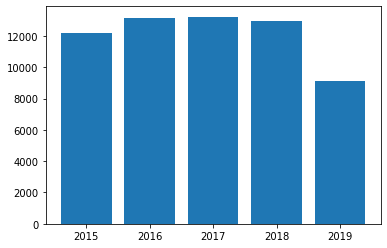

In [21]:
# incidents per year
inc_per_year = plt.bar(x = c['RESPONSEYEAR'], height = c['ID'])

In [32]:
# looking at most common incident locations
# response_data = response_data.round(6)
most_com_inc_loc = response_data[response_data['lat'] == 40.005051]
most_com_inc_loc.sort_values('RESPONSEDATE')

# cast rounded dataframe to file because this is annoying.
# MAYBE HAVE TO DO EVERYTIME?!?
# response_data.to_csv('data/BFD_fire.csv')